## Step 3: Scikit-learn to do machine learning! geoAI!! Buzzwords!!!

#### Make sure you have run the following notebooks before you run this one or you're going to have a bad time, son:
- 01-stratification-getdata.ipynb
- 02-stratification-preprocessing.ipynb

#### What happens in this notebook:

- Set the directory that contains the pre-processed raters
- read in all the rasters in that directory, and create an n-dimensional Xarray data array using `rioxarray`
- save the spatial metadata for one of those rasters, to be used for adding spatial data to the classified image once its been created
- transpose the data stack from (`band`,`y`,`x`) to (`y`,`x`,`band`) - yes, `y` is before `x`, that is not a typo or a mistake in the data ordering
- Transform the stacked rasters to a shape that can be fed to scikit learn's clustering algorithms
- use a standard scalar to resacle the data
    - This step needs further research. The data may also need to be normalised so that the data ranges are all within a similar scale. K-means and other classifiers are sensitive to skewed data
- Set the number of clusters and run a K-means unsupervised clustering algorithm (initiated with K-means++ for now)
- Once the classified image has been produced, turn it into a spatially referenced image - it won't have any spatial information at first, this needs to be added
- create and save the raster for the classification 

#### A note on actually using this notebook for delineating CEA's:
This POC does not include the step of first excluding areas with 20% or greater tree cover (which cannot be included for carbon projects). This POC just builds out the basic backbone of notebooks that allow us to input several rasters and person some terrain analysis, geometric operations and data reclassification to get a series of polygons representing 'similar areas' within the procided area of interest. 

Important information about managing loss of spatial metadata when doing xarray operations:

https://corteva.github.io/rioxarray/html/getting_started/manage_information_loss.html

In [44]:
%pip install scikit-learn -q
%pip install scikit-image -q
%pip install spectral -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [45]:
import os
import glob
import numpy as np
import geopandas as gpd
import rasterio
import rioxarray

import xarray as xr

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import grid_to_graph

from skimage.morphology import opening, square
from skimage.filters import median

import matplotlib.pyplot as plt

import holoviews as hv
import hvplot.xarray

In [46]:
input_dir = "/workspace/notebooks/sandbox/data/stratification/processed-rasters"
output_dir = "/workspace/notebooks/sandbox/data/stratification/stratification_results"


Read in all the rasters in the input directory, and concatenate them into a stacked `xarray` data array

In [47]:
input_rasters = []

for file in os.listdir(input_dir):
    if file.endswith(".tiff"):
        input_rasters.append(rioxarray.open_rasterio(os.path.join(input_dir, file)))

data_stack = xr.concat(input_rasters, dim="band")

We need to know the spatial metadata of one of the input geotiffs, as we will use this information to create a geotiff from the classified image. Read in one of the geotiffs and save it for later use.

In [48]:
# get spatial information from one of the raster to use for creating the classified raster
file_list = glob.glob(input_dir + "/*.tiff")
meta_raster_dir = file_list[0]

meta_raster = rioxarray.open_rasterio(meta_raster_dir)

meta_raster.attrs


{'AREA_OR_POINT': 'Area',
 '_FillValue': nan,
 'scale_factor': 1.0,
 'add_offset': 0.0}

drop any data that is `NaN` or an error will prevent the algorithm running. There shouldn't be any `NaN` data after the pre-processing steps, but this makes sure.

In [49]:
# # Assuming 'data_stack' is your xarray DataArray
data_stack = data_stack.dropna(dim='y', how='any')
data_stack = data_stack.dropna(dim='x', how='any')

In [50]:
data_stack_nan = data_stack.isnull().any()
print(f"Are there NaNs in the data stack? {data_stack_nan.values}")

Are there NaNs in the data stack? False


the n-dimension stacked data is transposed so that `band` is the 3rd dimension, not the first and then the transposed data stack is reshaped to a 2D array

In [51]:
# Assuming 'data_stack' is your xarray DataArray with dimensions (band, x, y)
data_stack_transposed = data_stack.transpose('y', 'x', 'band')

num_features = len(data_stack_transposed.band)  # Number of bands/features
X = data_stack_transposed.values.reshape(-1, num_features)  # Flatten spatial dimensions

print(f"shape of transposed data stack: {data_stack_transposed.shape}")
print("Shape of reshaped features array:", X.shape)

(492, 625, 3)


K-means clustering is sensitive to the scale of the data. If the features (e.g., DEM values versus carbon or clay percentages) are on very different scales, the clustering might be skewed towards the feature with larger values. It’s often a good practice to scale the data.

In [53]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

Set the number of clusters and run the clustering algorithm (K-means for now).

In [63]:
# Define number of clusters
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, init='k-means++')


kmeans.fit(scaled_features) #train it

x_cluster = kmeans.labels_ #get the labels of the classes
x_cluster_reshaped = x_cluster.reshape(data_stack_transposed[:,:,0].shape) #reshape to a 3D array with one band


plot the results as a scatter plot to assess the separability of the clusters and get an idea of how 'good' the results are. 

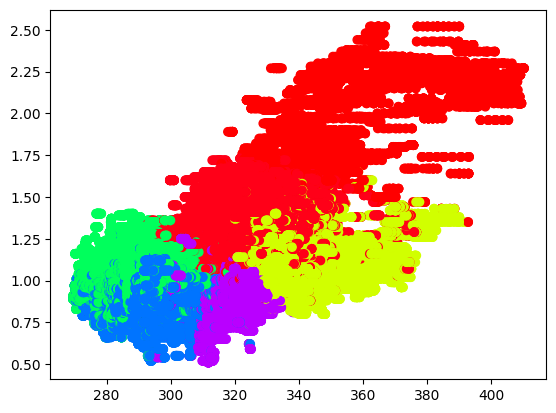

In [64]:
plt.scatter(X[:, 0], X[:, 1], c=x_cluster, cmap='hsv')  

Plot the result of the clustering algorithm

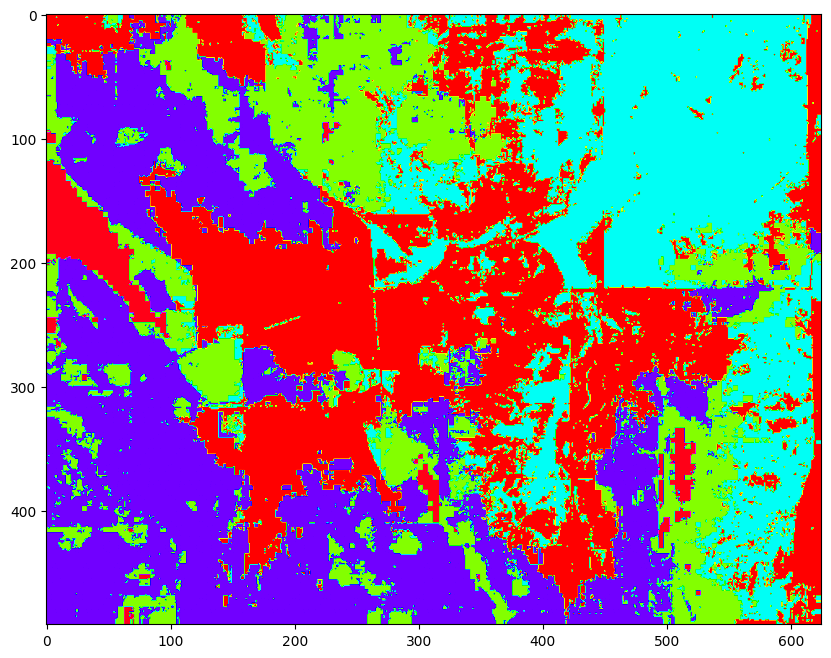

In [57]:
plt.figure(figsize=(10, 10))
plt.imshow(x_cluster_reshaped, cmap='hsv')

In [58]:
print("Shape of original data stack:", data_stack_transposed.shape)
print("Total number of elements in x_cluster:", len(x_cluster))


Shape of original data stack: (492, 625, 3)
Total number of elements in x_cluster: 307500


The clustering result is not a geotiff or a raster with any spatial information in it. We need to create a data array and add the results data to it, and then we need to add spatial data and metadata to the array as well so that it can be saved as a raster.

Finally, we save out the results as a geotiff with the same spatial extent, CRS and spatial resolution as the input geotiffs.

In [59]:
labels_da = xr.DataArray(
    x_cluster_reshaped, 
    coords={
        'y': data_stack.coords['y'],
        'x': data_stack.coords['x']
    },
    dims=['y', 'x']
)


In [60]:
labels_da.rio.write_crs(meta_raster.rio.crs, inplace=True)
labels_da.rio.write_transform(meta_raster.rio.transform(), inplace=True)
labels_da.rio.write_coordinate_system(inplace=True)

labels_da.rio.update_attrs(meta_raster.attrs, inplace=True)
labels_da.rio.update_encoding(meta_raster.encoding, inplace=True)
labels_da.rio.write_nodata(-9999, inplace=True)

<xarray.DataArray (y: 492, x: 625)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * y            (y) float64 4kB -3.404e+06 -3.404e+06 ... -3.415e+06 -3.415e+06
  * x            (x) float64 5kB 1.294e+07 1.294e+07 ... 1.296e+07 1.296e+07
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999
    scale_factor:   1.0
    add_offset:     0.0

In [61]:
print(labels_da.shape)
print(data_stack_transposed[:, :, 0].shape)  # Adjust depending on your dimension order


(492, 625)
(492, 625)


In [62]:
labels_da.rio.to_raster(os.path.join(output_dir, "kmeans_draft.tiff"))